# Setting

In [1]:
import numpy as np
import random 
import os
import sys
import pandas as pd
from tqdm import tqdm

import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

In [2]:
import tensorflow as tf 

from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate,AveragePooling1D
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping

from keras.optimizers import Adam, RMSprop, SGD

c:\ProgramData\Anaconda3\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (2.2.3) or chardet (4.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn(


## From here: 

In [3]:
TUNING_MODE = 'OFF' # ON/OFF
LOSS_FUNCTION = 'mse'

do_the_mcdropout_wc = True
do_the_mcdropout = True

METRIC = 'MAE'  # MAE/MSE

OPTIMIZER = 'adam' # adam, rmsprop
LR = 0.001   #adam과 rmsprop의 defaut값
BATCH_SIZE = 16
EPOCHS = 1200

PATIENCE = 30

#-------아직 구현 안 된 부분-------

DECAY_RATE=0.2
DECAY_STEP=200

# Import Data

In [4]:
model_path = './output/'
data_path = './data/'
auxiliary_folder = './data/'

In [5]:
data_train = np.load(data_path + 'data_train.npy')
data_train_FGS = np.load(data_path + 'data_train_FGS.npy')

data_test = np.load(auxiliary_folder + 'data_test.npy')
data_test_FGS = np.load(auxiliary_folder + 'data_test_FGS.npy')

data_train.shape, data_train_FGS.shape, data_test.shape, data_test_FGS.shape

((673, 187, 282, 32), (673, 187, 32, 32), (1, 187, 282, 32), (1, 187, 32, 32))

In [6]:
output_dir = './output'

SEED = 42

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory {output_dir} created")
else:
    print(f"Directory {output_dir} already exists")
    

Directory ./output already exists


# Preprocessing

In [7]:
train_solution = np.loadtxt(f'{auxiliary_folder}/train_labels.csv', delimiter = ',', skiprows = 1)
targets = train_solution[:, 1:]

targets_mean = targets[:, 1:].mean(axis = 1)

N = targets.shape[0]
print(N)

673


AIRS와 FGS 데이터를 결합시켜서 데이터셋을 만듦
- AIRS(주요 정보) + FGS(보조 정보)

In [8]:
train_signal_AIRS_diff_transposed_binned, train_signal_FGS_diff_transposed_binned = data_train, data_train_FGS
train_FGS_column = train_signal_FGS_diff_transposed_binned.sum(axis=2)
test_signal_AIRS_diff_transposed_binned, test_signal_FGS_diff_transposed_binned = data_test, data_test_FGS
test_FGS_column = test_signal_FGS_diff_transposed_binned.sum(axis=2)


dataset_train = np.concatenate([train_signal_AIRS_diff_transposed_binned, train_FGS_column[:,:, np.newaxis, :]], axis =2)
dataset_train = dataset_train.sum(axis=3)
dataset_test = np.concatenate([test_signal_AIRS_diff_transposed_binned, test_FGS_column[:,:, np.newaxis, :]], axis =2)
dataset_test = dataset_test.sum(axis=3)

In [9]:
dataset_train.shape, dataset_test.shape

((673, 187, 283), (1, 187, 283))

FGS 데이터에서 세 번째 축(axis=2)을 제거 -> 2D 배열로 변환
- y축의 픽셀을 합함, FGS_column 생성됨

AIRS와 FGS_column을 결합시킴 => 3D 배열로 결합됨

In [10]:
def create_dataset_norm(dataset1, dataset2):
    dataset_norm1 = np.zeros(dataset1.shape)
    dataset_norm2 = np.zeros(dataset1.shape)
    dataset_min = dataset1.min()
    dataset_max = dataset1.max()
    dataset_norm1 = (dataset1 - dataset_min) / (dataset_max - dataset_min)
    dataset_norm2 = (dataset2 - dataset_min) / (dataset_max - data_path)
    return dataset_norm1, dataset_norm2

def norm_star_spectrum(signal):
    img_star = signal[:,:50].mean(axis=1) + signal[:, -50:].mean(axis=1)
    return signal/img_star[:, np.newaxis, :]

dataset_train_norm = norm_star_spectrum(dataset_train)
dataset_train_norm = np.transpose(dataset_train_norm, (0,2,1))

dataset_test_norm = norm_star_spectrum(dataset_test)
dataset_test_norm = np.transpose(dataset_test_norm, (0,2,1))

dataset_train_norm.shape, dataset_test_norm.shape

((673, 283, 187), (1, 283, 187))

- 데이터셋 동일한 범위로 두 개를 정규화함
- 스펙트럼 처음과 마지막 50개의 평균값의 합으로 정규화함
- 샘플수, 파장, 시간축 순으로 정렬시킴

### Split dataset (train & validation)

white curve 생성
- 각 이미지의 모든 픽셀 값을 합산한 결과를 시간에 따라 나타낸 곡선

In [11]:
cut_inf, cut_sup = 39, 321
l = cut_sup - cut_inf + 1
wls = np.arange(l)

def split_train (data, N) : 
    list_planets = random.sample(range(0, data.shape[0]), N_train)
    list_index_1 = np.zeros(data.shape[0], dtype = bool)
    for planet in list_planets : 
        list_index_1[planet] = True
    data_1 = data[list_index_1]
    data_2 = data[~list_index_1]
    return data_1, data_2, list_index_1

N_train = 8*N//10

# Validation and train data split
train_obs_for_train, valid_obs_for_train, list_index_train = split_train(dataset_train_norm, N_train)
train_targets_for_train, valid_targets_for_train = targets[list_index_train], targets[~list_index_train]

In [12]:
train_signal_AIRS_diff_transposed_binned = train_signal_AIRS_diff_transposed_binned.sum(axis=3)
wc_mean = train_signal_AIRS_diff_transposed_binned.mean(axis=1).mean(axis=1)
white_curve_for_train = train_signal_AIRS_diff_transposed_binned.sum(axis=2)/ wc_mean[:, np.newaxis]
print(f'white_curve: {white_curve_for_train.shape}')

white_curve: (673, 187)


In [13]:
test_signal_AIRS_diff_transposed_binned = test_signal_AIRS_diff_transposed_binned.sum(axis=3)
wc_mean = test_signal_AIRS_diff_transposed_binned.mean(axis=1).mean(axis=1)
test_wc = test_signal_AIRS_diff_transposed_binned.sum(axis=2)/ wc_mean[:, np.newaxis]
print(f'white_curve: {test_wc.shape}')

white_curve: (1, 187)


지금 normalize 로직이 조금 이상하네요..
만약 각 항성 단위로 mean값 구해 normalize하는게 목적이었다면 이게 아니라 각각의 \
행성데이터에서 max, min값 구해야하고\
그게아니라면 train과 valid 전체에서 min, max값 구하고, test도 그 값으로 \
normalize해야할거예요\
일단 지금은 Host starter solution이 제공한 거 그대로 해보겠습니다

In [14]:
def normalise_wlc(train, valid, test) :
    wlc_train_min = min(train.min(), valid.min())
    wlc_train_max = min(train.max(), valid.max())
    train_norm = (train - wlc_train_min) / (wlc_train_max - wlc_train_min)
    valid_norm = (valid - wlc_train_min) / (wlc_train_max - wlc_train_min)
    test_norm = (test - wlc_train_min) / (wlc_train_max - wlc_train_min)
    return train_norm, valid_norm, test_norm

def normalize (train, valid) : 
    max_train = train.max()
    min_train = train.min()
    train_norm = (train - min_train) / (max_train - min_train)
    valid_norm = (valid - min_train) / (max_train - min_train)
    return train_norm, valid_norm, min_train, max_train

In [15]:
train_wc, valid_wc = white_curve_for_train[list_index_train], white_curve_for_train[~list_index_train]
print(f'train_wc: {train_wc.shape}, valid_wc: {valid_wc.shape}')
print(f'train_wc: {train_wc.max()}, valid_wc: {valid_wc.max()}')

train_wc: (538, 187), valid_wc: (135, 187)
train_wc: 283.26989129295697, valid_wc: 283.0540607417518


In [16]:
train_targets_wc, valid_targets_wc = targets_mean[list_index_train], targets_mean[~list_index_train]

train_wc, valid_wc, test_wc = normalise_wlc(train_wc, valid_wc, test_wc)

# Normalize the targets 
train_targets_wc_norm, valid_targets_wc_norm, min_train_valid_wc, max_train_valid_wc = normalize(train_targets_wc, valid_targets_wc)

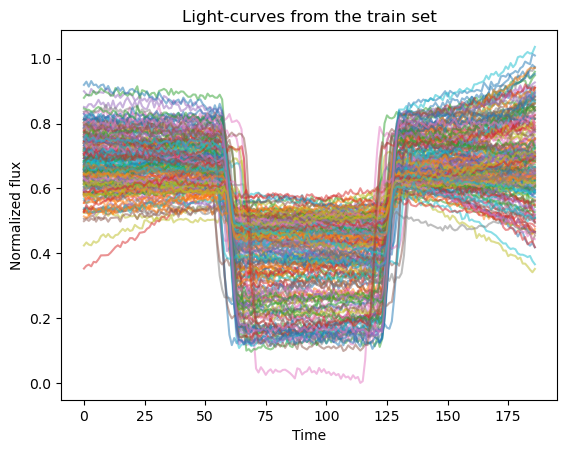

In [17]:
plt.figure()
for i in range(200):
    plt.plot(train_wc[-i], '-', alpha=0.5)
plt.title('Light-curves from the train set')
plt.xlabel('Time')
plt.ylabel('Normalized flux')
plt.show()

# Model train

### 1D CNN

In [18]:
input_wc = Input((187,1))
x = Conv1D(32, 3, activation='relu')(input_wc)
x = MaxPooling1D()(x)
x = BatchNormalization() (x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D()(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D()(x)
x = Conv1D(256, 3, activation='relu')(x)
x = MaxPooling1D()(x)
x = Flatten()(x)

x = Dense(500, activation='relu')(x)
x = Dropout(0.2)(x, training = True)
x = Dense(100, activation='relu')(x)
x = Dropout(0.1)(x, training = True)
output_wc = Dense(1, activation='linear')(x)

model_wc = Model(inputs=input_wc, outputs=output_wc)
model_wc.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 187, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 185, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 92, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 92, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 90, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 45, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 43, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 19, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 9, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │     1,152,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        50,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,332,429 (5.08 MB)

 Trainable params: 1,332,365 (5.08 MB)

 Non-trainable params: 64 (256.00 B)

In [19]:
early_stopping = EarlyStopping(
    monitor ='val_loss',
    patience = PATIENCE,
    restore_best_weights = True
)

### Train Model

In [20]:
def scheduler(epoch, lr):
    decay_rate = DECAY_RATE
    decay_step = DECAY_STEP
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

model_wc.compile(optimizer = OPTIMIZER, loss='mse', metrics=[MeanAbsoluteError()])
callback = LearningRateScheduler(scheduler)
checkpoint_filepath = 'output/model_1dcnn.keras'
model_ckt = ModelCheckpoint(
    checkpoint_filepath,
    monitor = 'val_loss',
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    mode = 'min',
    save_freq = 'epoch'
)

history = model_wc.fit(
    x = train_wc,
    y = train_targets_wc_norm,
    validation_data = (valid_wc, valid_targets_wc_norm),
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    shuffle = True,
    verbose = 0,
    callbacks=[model_ckt]
)
print('Done training')

Done training


### Model Eval

#### Learning curve

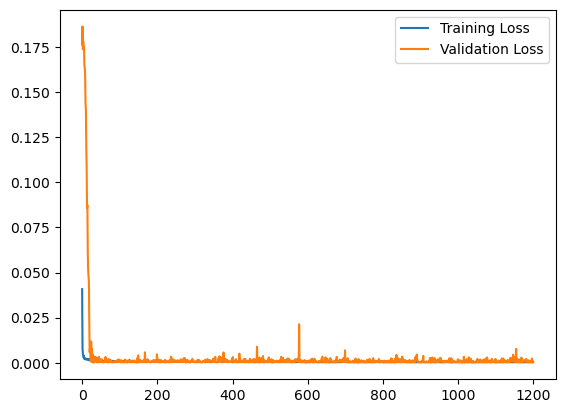

In [21]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

#### MSE

MC Dropout - prediction result의 평균, 불확실성 추정

In [22]:
nb_dropout_wc = 1000

def unstandardizing(data, min_train_valid, max_train_valid):
    return data*(max_train_valid - min_train_valid)+min_train_valid

def MC_dropout_WC(model, data, nb_dropout):
    predictions = np.zeros((nb_dropout, data.shape[0]))
    for i in range(nb_dropout):
        predictions[i, :] = model.predict(data, verbose=0).flatten()
    return predictions

if do_the_mcdropout_wc:
    print('Running...')
    prediction_valid_wc = MC_dropout_WC(model_wc, valid_wc, nb_dropout_wc)
    spectre_valid_wc_all = unstandardizing(prediction_valid_wc, min_train_valid_wc, max_train_valid_wc)
    spectre_valid_wc, spectre_valid_std_wc = spectre_valid_wc_all.mean(axis=0), spectre_valid_wc_all.std(axis=0)
    print('Done')
else:
    spectre_valid_wc = model_wc.predict(valid_wc).flatten()
    spectre_valid_wc = unstandardizing(spectre_valid_wc, min_train_valid_wc, max_train_valid_wc)
    spectre_valid_std_wc = 0.1*np.abs(spectre_valid_wc)

Running...
Done


residual 분석

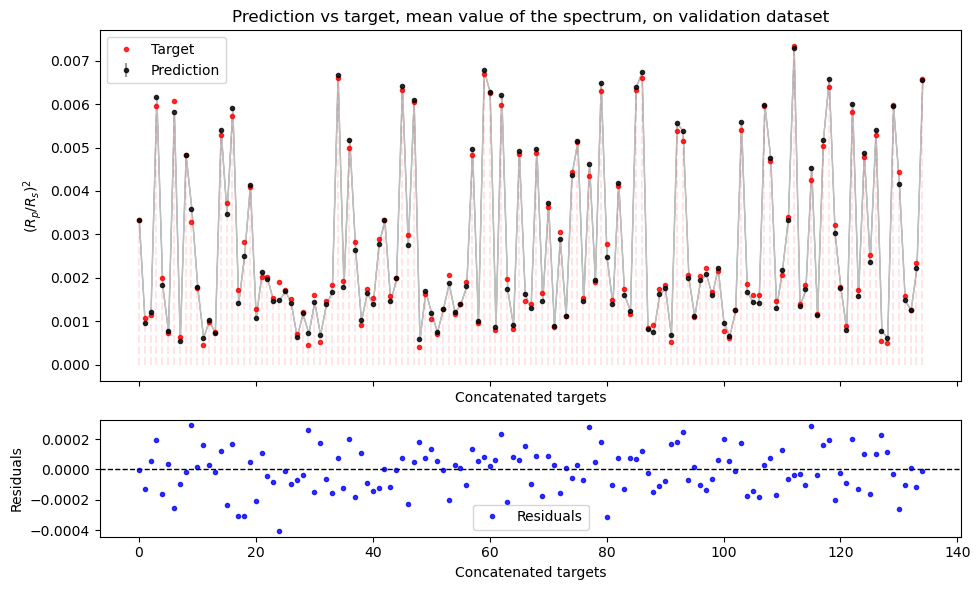

In [23]:
residuals = spectre_valid_wc - valid_targets_wc
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]})
ax1.errorbar(x = np.arange(len(spectre_valid_wc)), y = spectre_valid_wc, yerr =spectre_valid_std_wc, fmt = '.', color = 'k', ecolor = 'gray', label='Prediction', alpha=0.8)
ax1.fill_between(np.arange(len(spectre_valid_wc)), spectre_valid_wc - spectre_valid_std_wc, spectre_valid_wc + spectre_valid_std_wc, color = 'grey', alpha = 0.5)
ax1.vlines(np.arange(len(spectre_valid_wc)),ymin=0, ymax=spectre_valid_wc, colors='r', linestyle='dashed',alpha = 0.1)
ax1.plot(valid_targets_wc, 'r.', label='Target', alpha=0.8)
ax1.set_xlabel('Concatenated targets')
ax1.set_ylabel('$(R_p/R_s)^2$')
ax1.set_title('Prediction vs target, mean value of the spectrum, on validation dataset')
ax1.legend()

ax2.plot(residuals, 'b.', label='Residuals', alpha=0.8)
ax2.set_xlabel('Concatenated targets')
ax2.set_ylabel('Residuals')
ax2.axhline(0, color='black', linestyle='--', linewidth=1)  
ax2.legend()
plt.tight_layout()
plt.show()

In [24]:
residuals = valid_targets_wc - spectre_valid_wc
print('MSE : ', np.sqrt((residuals**2).mean())*1e6, 'ppm')

MSE :  141.77705783549118 ppm


# Load Model, Testset

완성한 모델, testset 저장해두기. *이후 `model_concat`에서 부를 예정*

In [25]:
model_wc.save(output_dir+'/model_cnn1d.h5')
np.save(output_dir+'/testset_1d.npy', test_wc)